Source to following code: https://pythonprogramming.net/convolutional-neural-network-deep-learning-python-tensorflow-keras/
<br>
Second source is: https://towardsdatascience.com/deeppicar-part-5-lane-following-via-deep-learning-d93acdce6110

In [127]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [128]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [129]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? n
Nothing done.


In [130]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from keras.models import Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split 
from sklearn.utils import shuffle

import statistics
import gc # Helps to clear up some ram

import cv2
from numpy import random
from imgaug import augmenters as img_aug

import math
import os

In [131]:
tf.random.set_seed(1)

In [132]:
import pickle

path = "/content/drive/My Drive/AutonomousDriving"
pickle_in = open(path+"/trainColour.pickle","rb")
# Remove binary version
trainImagesAndLabels = pickle.load(pickle_in)

imageId = []
bigImage = []
y_angle = []
y_speed = []
for id,image,lbl_angle,lbl_speed in trainImagesAndLabels:
  #checking = image
  if np.count_nonzero(pd.isnull(image)): 
    print("NA: This image was not read well so we will skip for now")
  else:
    imageId.append(id)
    bigImage.append(image)
    y_angle.append(lbl_angle)
    y_speed.append(lbl_speed)

Standard deviation of the angles

In [133]:
def shrinkImage(image):
  image = image[80:240,:,:]  # remove top half of the image, as it is not relevant for lane following
  image = cv2.resize(image, (0,0), fx=0.6, fy=0.6)# Need to reduce  size to conserve memory
  return image



In [134]:
X = []
for image in bigImage:
  X.append(shrinkImage(image))
del bigImage

In [135]:
# plt.hist(y_speed)
# statistics.stdev(y_speed)

In [136]:
def pan(image):
    # pan left / right / up / down about 10%
    pan = img_aug.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image
    
def zoom(image):
    zoom = img_aug.Affine(scale=(1, 1.3))  # zoom from 100% (no zoom) to 130%
    image = zoom.augment_image(image)
    return image

def adjust_brightness(image):
    # increase or decrease brightness by 30%
    brightness = img_aug.Multiply((0.7, 1.3))
    image = brightness.augment_image(image)
    return image

def blur(image):
    kernel_size = random.randint(1, 5)  # kernel larger than 5 would make the image way too blurry
    image = cv2.blur(image,(kernel_size, kernel_size))
   
    return image


def random_flip(image,speed):
    is_flip = random.randint(0, 1)
    if is_flip == 1:
        # randomly flip horizon
        image = cv2.flip(image,1)
        
   
    return image, speed

In [137]:
def random_augment(image, speed, angle):
  
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = blur(image)
    if np.random.rand() < 0.5:
        image = adjust_brightness(image)
    image, speed = random_flip(image, speed)
    
    return image, speed, angle
# imageId = np.array(imageId)

In [138]:
smallSpeeds=(np.where(np.array(y_speed)<0.5)[0])
bigSpeeds=(np.where(np.array(y_speed)>0.5)[0])


augmentedImages = []
augmentedSpeed = []
augmentedAngle = []
augmentedID = []

# for _ in range(1):
#   for idx in bigSpeeds:  
#       image, speed,angle = random_augment(X[idx], y_speed[idx],y_angle[idx])
#       augmentedImages.append(image)
#       augmentedSpeed.append(speed)
#       augmentedAngle.append(angle)
#       augmentedID.append(imageId[idx])

In [139]:
len(y_angle)

13793

In [140]:
for _ in [1,2,3,4]:
  for idx in smallSpeeds:
      image, speed, angle = random_augment(X[idx], y_speed[idx], y_angle[idx])
      augmentedImages.append(image)
      augmentedSpeed.append(speed)
      augmentedAngle.append(angle)
      augmentedID.append(imageId[idx])

Hist before augmentation

(array([3.3900e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0402e+04, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([0.        , 0.14285714, 0.28571429, 0.42857143, 0.57142857,
        0.71428571, 0.85714286, 1.        , 1.14285714, 1.28571429,
        1.42857143]),
 <a list of 10 Patch objects>)

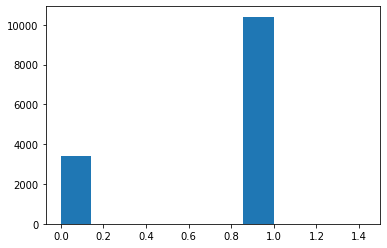

In [141]:
plt.hist(y_speed)
# statistics.stdev(y_speed)

Hist after augmentation

In [142]:
for idx in range(len(augmentedSpeed)):
  y_speed.append(augmentedSpeed[idx])
  y_angle.append(augmentedAngle[idx])
  X.append(augmentedImages[idx])
  imageId.append(augmentedID[idx])
del augmentedImages
del augmentedSpeed
del augmentedAngle
del augmentedID


(array([1.6950e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0402e+04, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([0.        , 0.14285714, 0.28571429, 0.42857143, 0.57142857,
        0.71428571, 0.85714286, 1.        , 1.14285714, 1.28571429,
        1.42857143]),
 <a list of 10 Patch objects>)

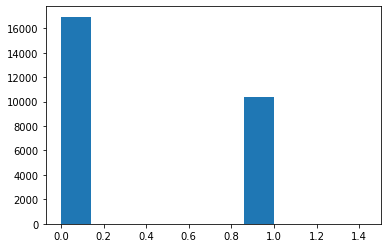

In [143]:
plt.hist(np.array(y_speed))
# statistics.stdev(y_speed)

In [144]:
X_new = X
y_speed_new = y_speed
idImage = imageId
del X
del y_speed
del imageId
del pickle_in

10707
0.0


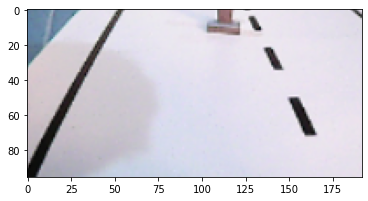

In [145]:
print(idImage[-1])
print(y_speed_new[-1])
plt.imshow(X_new[-1])

In [146]:
X_new = np.array(X_new)
y_speed_new = np.array(y_speed_new)
idImage = np.array(idImage)

10707
0.0


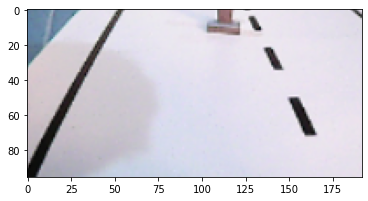

In [147]:
print(idImage[-1])
print(y_speed_new[-1])
plt.imshow(X_new[-1])

Shuffle the two X_new and y_angle arrays. Note that sklearn shuffle allows us to shuffle two arrays as they were together

Preprocces images to scale, normalize change RGB to YUV and add gaussian noise

In [148]:
def img_preprocess(image):
    height, width, _ = image.shape

    # in the case that there exists an object in the image of interest DO NOT MAKE reduce the height of the image!!
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Nvidia model said it is best to use YUV color space
    # image = cv2.GaussianBlur(image, (3,3), 0) # Gaussian Noise / filtering

    image = image / 255 # normalizing
    # Round everything into the image to 1 decimal place
    image = np.around(image ,2)
    return image

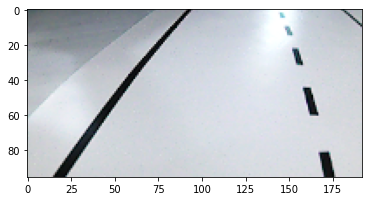

In [149]:
# img = cv2.resize(X_new[0], (240,113))
# plt.imshow(img)
plt.imshow(X_new[0])

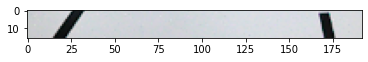

In [150]:
plt.imshow(X_new[0][80:240,:,:])

# Split before preprocess to object detect

In [151]:
# X_image_train_temp, X_image_test_temp, X_angle_train, X_angle_test, y_train, y_test = train_test_split(X_new, y_angle, y_speed_new, test_size=0.1, random_state=42)
# del X_new

In [152]:
# X_train = []
# for img_index in range(X_image_train_temp.shape[0] ):
#   X_f = img_preprocess(X_image_train_temp[img_index,:,:,:])
#   X_train.append(X_f)
# X_image_train = np.array(X_train)

# del X_train

# X_test = []
# for img_index in range(X_image_test_temp.shape[0] ):
#   X_f = img_preprocess(X_image_test_temp[img_index,:,:,:])
#   X_test.append(X_f)
# X_image_test = np.array(X_test)
# del X_test

In [157]:
 X_final = []
for img_index in range(X_new.shape[0] ):
  X_f = img_preprocess(X_new[img_index,:,:,:])
  X_final.append(X_f)
X_final = np.array(X_final)
y_angle = np.array(y_angle)

In [158]:
#shuffle x and y together
perms = np.random.permutation(len(X_final))
X_image_train = X_final[perms]
y_train = y_speed_new[perms]
idImage = idImage[perms]
X_angle_train = y_angle[perms]
del y_speed_new
del X_final

In [ ]:
# del y_angle

Create a test dataset to ensure that we do not overfit

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split( X_final, y_speed_new, test_size=0.1, random_state=42)

In [ ]:
# y_angle = np.array(y_angle)
# X_image_train, X_image_test, X_angle_train, X_angle_test, y_train, y_test = train_test_split(X_final, y_angle, y_speed_new, test_size=0.1, random_state=42)

In [ ]:
# plt.imshow(X_train[22])#,:,:,:])
# print(y_train[22])
# print(idImage[22])

In [160]:
# X_angle_test = np.array(X_angle_test)
X_angle_train = np.array(X_angle_train)


tf_y_train = tf.reshape(y_train,[ y_train.shape[0] ,1 ]).numpy()
tf_X_angle_train = tf.reshape(X_angle_train,[ X_angle_train.shape[0] ,1 ]).numpy()
# tf_X_angle_test = tf.reshape(X_angle_test,[ X_angle_test.shape[0] ,1 ]).numpy()
print(y_train.shape)
print(tf_y_train.shape)
if len(X_image_train.shape) == 3:
  #X_train = tf.reshape(X_train,[ X_train.shape[0],X_train.shape[1],X_train.shape[2] ,1 ]).numpy()
  X_image_train = np.reshape(X_image_train, (X_image_train.shape[0],X_image_train.shape[1],X_image_train.shape[2] ,1 ) )
  #X_train = np.repeat(X_train[..., np.newaxis], 3, -1)



(27353,)
(27353, 1)


In [ ]:
gc.collect()

In [161]:
def angle_feat_model():
  # model = Sequential(name='angle input')
  input = Input(shape=1)
  x= (Dense(1,activation ='relu'))(input)
  x = Dense(100,activation ='relu')(x)
  # x = Dense(200,activation ='relu')(x)
  # x = (Dense(50, activation = 'relu'))(x)
  output = x
  model = Model(inputs=input,outputs=output)
  return model

angle_top_model = angle_feat_model()
# angle_top_model.summary()

In [162]:
X_image_train.shape[1]

96

In [163]:
def nvidia_top_model():
    
    
    # elu=Exponential Linear Unit, similar to leaky Relu
    # skipping 1st hiddel layer (nomralization layer), as we have normalized the data
    
    # Convolution Layers
    inputs = Input(shape=(X_image_train.shape[1], X_image_train.shape[2], X_image_train.shape[3]))
    x = BatchNormalization()(inputs)
    x = (Conv2D(24, (5, 5), strides=(2, 2), activation='elu',))(x)#(inputs)# input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation='elu')) 
    x = (Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))(x)
    x = MaxPooling2D(padding='same')(x)
    x = (Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))(x)
    # x = MaxPooling2D(padding='same')(x)
    x = (Conv2D(64, (3, 3), activation='elu'))(x) 
    #model.add(Dropout(0.2)) # not in original model. added for more robustness
    x = (Conv2D(64, (1, 1), activation='elu'))(x)  
    
    # Fully Connected Layers
    x = (Flatten())(x)
    x = (Dense(200, activation='elu'))(x)

    x = (Dropout(0.1))(x) # not in original model. added for more robustness
    x = (Dense(100, activation='elu'))(x)
    #model.add(Dense(100, activation='elu'))
    # x = (Dropout(0.1))(x)
    # x = (Dense(50, activation='elu'))(x)
    #model.add(Dense(50, activation='elu'))
    #model.add(Dropout(0.05))
    # x = (Dense(10, activation='elu'))(x)
    outputs = x
    #model.add(Dense(10, activation='elu'))
    
    model = Model(inputs=inputs, outputs=outputs )
    return model

nvidia_top_model = nvidia_top_model()
print(nvidia_top_model.summary())

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 96, 192, 1)]      0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 96, 192, 1)        4         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 46, 94, 24)        624       
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 21, 45, 36)        21636     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 11, 23, 36)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 4, 10, 48)         43248     
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 2, 8, 64)          277

In [164]:
from keras.layers import *


mergedOut = Add()([nvidia_top_model.output,angle_top_model.output])

mergedOut = Flatten()(mergedOut)    
# mergedOut = Dense(50, activation='relu')(mergedOut)
# mergedOut = Dense(200, activation='elu')(mergedOut)
mergedOut = Dense(100, activation='elu')(mergedOut)
mergedOut = Dense(50, activation='elu')(mergedOut)
mergedOut = Dense(10, activation='elu')(mergedOut)
# mergedOut = Dropout(.1)(mergedOut)
# mergedOut = Dense(5, activation='relu')(mergedOut)
# mergedOut = Dropout(.1)(mergedOut)

# output layer
mergedOut = Dense(1, activation='sigmoid')(mergedOut)

In [165]:
# np.corrcoef(y_angle,y_speed_new)

In [166]:
from keras.models import Model

mergeModel = Model([nvidia_top_model.input, angle_top_model.input], mergedOut)
optimizer = Adam(lr=1e-3)
mergeModel.compile(loss='binary_crossentropy',
                  optimizer=optimizer,               
                  metrics=['accuracy'])
mergeModel.summary()

Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 96, 192, 1)] 0                                            
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 96, 192, 1)   4           input_16[0][0]                   
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 46, 94, 24)   624         batch_normalization_9[0][0]      
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 21, 45, 36)   21636       conv2d_44[0][0]                  
___________________________________________________________________________________________

In [ ]:
X_angle_train

In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
        patience=7, verbose=1, mode='auto',
        restore_best_weights=True)
mergeModel.fit([X_image_train,X_angle_train], tf_y_train, batch_size=32, epochs=100, validation_split=0.2,callbacks=[monitor])  

In [168]:
mergeModel.evaluate(x=[X_image_test,X_angle_test],y=y_test)

NameError: ignored

In [170]:
mergeModel.save(os.path.join(path,'Speed_prediction_model.h5'))

In [ ]:
# def nvidia_model():
#
#     model = Sequential(name='Nvidia_Model')
    
#     # elu=Exponential Linear Unit, similar to leaky Relu
#     # skipping 1st hiddel layer (nomralization layer), as we have normalized the data
    
#     # Convolution Layers
#     model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation='elu')) 
#     model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu')) 
#     model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu')) 
#     model.add(Conv2D(64, (3, 3), activation='elu')) 
#     #model.add(Dropout(0.2)) # not in original model. added for more robustness
#     model.add(Conv2D(64, (3, 3), activation='elu'))  
    
#     # Fully Connected Layers
#     model.add(Flatten())
#     model.add(Dense(200, activation='elu'))

#     model.add(Dropout(0.1)) # not in original model. added for more robustness
#     model.add(Dense(100, activation='elu'))
#     #model.add(Dense(100, activation='elu'))
#     model.add(Dropout(0.1))
#     model.add(Dense(50, activation='elu'))
#     #model.add(Dense(50, activation='elu'))
#     #model.add(Dropout(0.05))
#     model.add(Dense(10, activation='elu'))
#     #model.add(Dense(10, activation='elu'))
    
#     # output layer: turn angle (from 45-135, 90 is straight, <90 turn left, >90 turn right)
#     model.add(Dense(1, activation='sigmoid')) 
    
#     #optimizer = Adam(lr=1e-7) # lr is learning rate
#     optimizer = Adam(lr=1e-3)
#     model.compile(loss='binary_crossentropy',
#                   optimizer=optimizer,               
#                   metrics=['accuracy'])

#     return model

# model = nvidia_model()
# print(model.summary())

In [ ]:
# monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
#         patience=7, verbose=1, mode='auto',
#         restore_best_weights=True)
# model.fit(X_train, tf_y_train, batch_size=32, epochs=100, validation_split=0.2,callbacks=[monitor])

In [ ]:
# model.evaluate(x=X_test,y=y_test)

In [ ]:
# model.save(os.path.join(path,'Speed_prediction_model.h5'))

In [ ]:
# speed = model.predict(X_test)

In [ ]:
# speed = np.round(speed,0)

In [ ]:
# bce = tf.keras.metrics.BinaryAccuracy()
# bce(y_test, speed).numpy()





Object detect for traffic lights and to create data for speed model



In [ ]:
# %cd "/content/drive/My Drive/AutonomousDriving/Github/AutonomousCars/Tensorflow/models/research/"
# mainPath = r"/content/drive/My Drive/AutonomousDriving/Github/AutonomousCars"
# modelPath = mainPath + r"/Tensorflow/workspace/exported-models/my_model/saved_model"
# labelPath = mainPath + r"/Tensorflow/workspace/annotations/label_map.pbtxt"
# imgPath = mainPath + r"/data/test_data/test_data"

In [ ]:
# import tensorflow as tf
# import time
# from object_detection.utils import label_map_util
# from object_detection.utils import visualization_utils as viz_utils
# print('Loading model...', end='')
# # Load saved model and build the detection function
# detect_fn=tf.saved_model.load(modelPath)
# print('Done!')
# category_index=label_map_util.create_category_index_from_labelmap(labelPath, use_display_name=True)

In [ ]:
# import numpy as np
# from PIL import Image
# import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings('ignore')
# %matplotlib inline
# plt.rcParams.update({'font.size': 12})

In [ ]:
# redLightIndexes = []
# for idx in range(len(X_test_normal)):
#   image = X_test_normal[idx]
#   image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#   input_tensor=tf.convert_to_tensor(image)
#   input_tensor=input_tensor[tf.newaxis, ...]
#   detections=detect_fn(input_tensor)
#   num_detections=int(detections.pop('num_detections'))
#   detections={key:value[0,:num_detections].numpy()
#                  for key,value in detections.items()}
#   detections['num_detections'] = num_detections
#   detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
#   #for visualisation uncomment below

#   image_np_with_detections=image.copy()
#   viz_utils.visualize_boxes_and_labels_on_image_array(
#         image_np_with_detections,
#         detections['detection_boxes'],
#         detections['detection_classes'],
#         detections['detection_scores'],
#         category_index,
#         use_normalized_coordinates=True,
#         max_boxes_to_draw=100,     
#         min_score_thresh=.5,      
#         agnostic_mode=False) 
#   indexes = np.where(detections['detection_scores']>0.5)
#   boxes = detections['detection_classes'][indexes]
#   if 4 in boxes:
#     speed[idx] = 0
#     redLightIndexes.append(idx)  
#     print(f"index:{idx} Image ID:")# {imageId[idx]}")
#   if idx % 50 == 0:
#     print(idx)


In [ ]:
# bce = tf.keras.metrics.BinaryAccuracy()
# bce(y_test, speed).numpy()

In [ ]:
# plt.imshow(X_test_normal[17])

In [ ]:
# gc.collect()  

In [ ]:
# errors = []
# for i in range(y_test.shape[0]):
#   if speed[i]-y_test[i] != 0:
#     errors.append(i)

#   #print([steering_angle[i][0], tf_y_angle[i][0]])
#   # print([speed[i][0], y_test[i] ])
# errors

In [ ]:
# len(errors)

In [ ]:
# error = errors[9]
# plt.imshow(X_test[error]);
# print(y_test[error])
# print(speed[error])

In [ ]:
# x= 0
# for i in range(y_test.shape[0]):
#   x += speed[i][0]-y_test[i]
# print(x)

In [ ]:
# plt.hist(y_speed_new)

Calculate the Mean squared error

In [ ]:
# mseSum = 0
# print(y_test.shape[0])
# for i in range(y_test.shape[0]):
#   mseSum += (1/y_test.shape[0] ) *  (steering_angle[i][0] - y_test[i])**2
# print(mseSum)

In [ ]:
# model.save(os.path.join(path,'Speed_prediction_model.h5'))

In [ ]:
# del model

Now save the model output